## Jonathon Desiderio | 2021 Beer Case Study

In [1]:
import pandas as pd
import numpy as np
from afinn import Afinn
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
from datetime import datetime
import seaborn as sns
import scipy.stats as stats
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics.pairwise import cosine_similarity

I am first starting with some cleaning/preprocessing and checking distributions to see how I will carry out my analysis

In [2]:
df = pd.read_csv('beer.csv', encoding='latin-1')

In [12]:
df.isna().sum()

beer_ABV              20280
beer_beerId               0
beer_brewerId             0
beer_name                 0
beer_style                0
review_appearance         0
review_palette            0
review_overall            0
review_taste              0
review_profileName      115
review_aroma              0
review_text             119
review_time               0
dtype: int64

In [3]:
df = df[df['review_text'].notna()]
df = df[df['beer_ABV'].notna()]

In [87]:
sub = df.groupby('beer_brewerId')['beer_name'].nunique()

C:\Users\jonat\AppData\Local\Programs\Python\Python38-32\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='beer_ABV', ylabel='Density'>

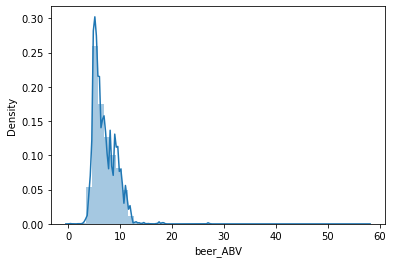

In [119]:
sns.distplot(df['beer_ABV'])

C:\Users\jonat\AppData\Local\Programs\Python\Python38-32\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='beer_name', ylabel='Density'>

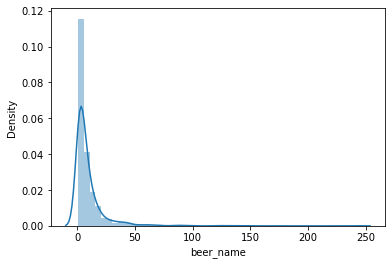

In [120]:
sns.distplot(sub)

C:\Users\jonat\AppData\Local\Programs\Python\Python38-32\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


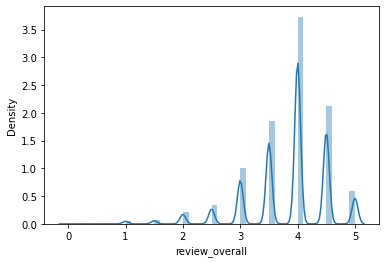

In [124]:
sns.distplot(df['review_overall'])

## Rank top 3 Breweries which produce the strongest beers?

I used the median to estimate which breweries produced the strongest beers.  I did this because the distruibution for the ABV wasn't normal, it was postively skewed.  I made both plots for the audience to observe.  In a more robust analysis, I would have removed outliers like Brewers who produced below 3 standard deviations off the mean amount of beers.

In [112]:
def get_top_3(statistic):
    if statistic == 'mean':
        sub = df.groupby('beer_brewerId')['beer_ABV'].mean()
        f = sub.to_frame()
        test = f.sort_values(['beer_ABV'], ascending=[False])
        test = test.head(7)
        c = ['green', 'green', 'green', 'red', 'red', 'red', 'red']
        ax = test['beer_ABV'].plot(kind="bar", title="test", color = c)
        ax.set_xlabel('Average ABV')
        ax.set_ylabel('Brewer ID')
        ax.set_title('Top 3 Brewers who produce the strongest beers (by mean)')
        plt.show()
    if statistic == 'median':
        sub2 = df.groupby('beer_brewerId')['beer_ABV'].median()
        f2 = sub2.to_frame()
        test_2 = f2.sort_values(['beer_ABV'], ascending=[False])
        test2 = test_2.head(7)
        c = ['green', 'green', 'green', 'red', 'red', 'red', 'red']
        ax = test2['beer_ABV'].plot(kind="bar", title="test", color = c)
        ax.set_xlabel('Median ABV')
        ax.set_ylabel('Brewer ID')
        
        ax.set_title('Top 3 Brewers who produce the strongest beers (by median)')
        plt.show()

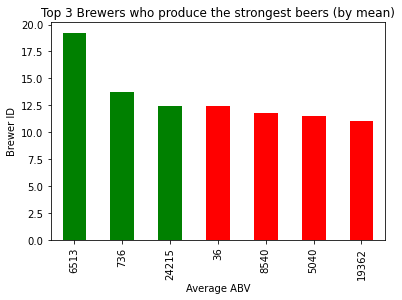

In [113]:
get_top_3('mean')

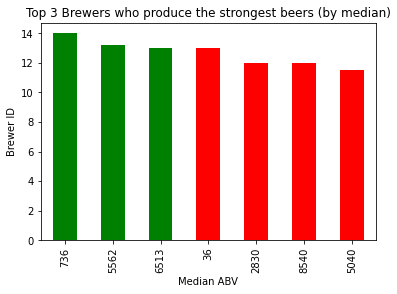

In [114]:
get_top_3('median')

Based of this analysis of the median ABV by Brewers, the top three brewer_id's are: 1). 736, 2). 5562, 3). 6513

## Which year did beers enjoy the highest ratings? 

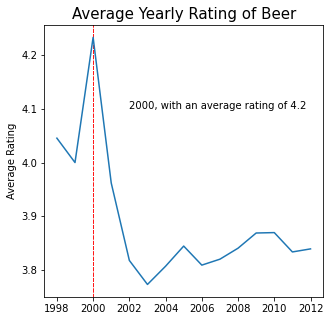

In [126]:
df['date'] = pd.to_datetime(df['review_time'],unit='s')
df['year'] = pd.DatetimeIndex(df['date']).year
yea = df.groupby('year')['review_overall'].mean()
averages = yea.to_list()
years = list(yea.index)

fig, ax = plt.subplots(figsize=(5, 5))
ymin, ymax = plt. ylim()
ax.plot(years, averages)
ax.set_ylabel("Average Rating")
ax.set_title("Average Yearly Rating of Beer", size=15)
ax.axvspan(2000, 2000, color="red", alpha=0.9, linestyle = '--')
plt.text(2002, 4.1, '2000, with an average rating of 4.2')
plt.show()

The year 2000 reported the highest mean rating of beer, with an average rating above 4.2.

## Based on the user’s ratings which factors are important among taste, aroma, appearance, and palette?

The approach I took for this question was oriented around comparing the feature to the overall rating, and selecting the correlation with the highest magnitude.  Another analysis one could undertake would to model this data in a regression, and see what feature ranks highest on the feature importance.

In [104]:
def get_cor_plot(x_val, y_val):
    graph = sns.jointplot(x = df[x_val], y = df[y_val], kind = "reg")
    r, p = stats.pearsonr(df[x_val], df[y_val])
    phantom, = graph.ax_joint.plot([], [], linestyle="", alpha=0)
    graph.ax_joint.legend([phantom],['r={:f}, p={:f}'.format(r,p)])
    return 'Scatter plot of {} and {} with Correlation Coefficent'.format(x_val, y_val)

'Scatter plot of review_taste and review_overall with Correlation Coefficent'

C:\Users\jonat\AppData\Roaming\Python\Python38\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


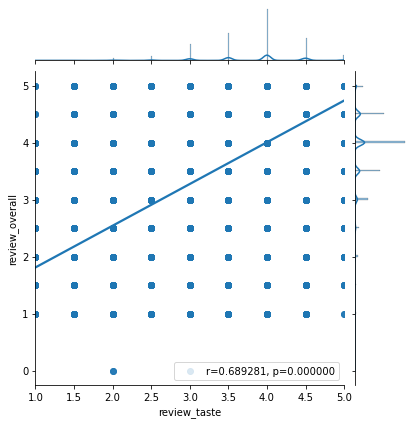

In [92]:
get_cor_plot('review_taste', 'review_overall')

'Scatter plot of review_aroma and review_overall with Correlation Coefficent'

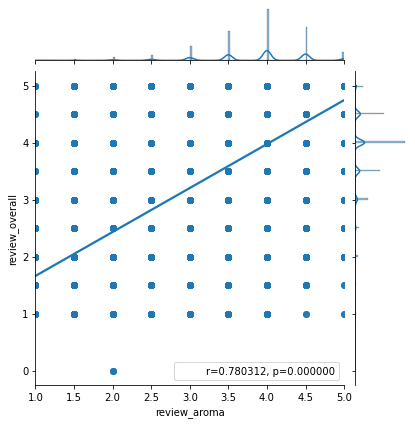

In [99]:
get_cor_plot('review_aroma', 'review_overall')

'Scatter plot of review_appearance and review_overall with Correlation Coefficent'

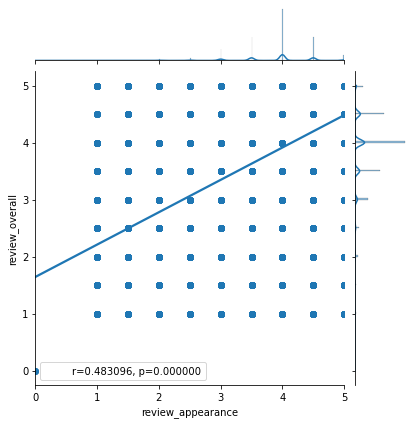

In [100]:
get_cor_plot('review_appearance', 'review_overall')

'Scatter plot of review_palette and review_overall with Correlation Coefficent'

C:\Users\jonat\AppData\Roaming\Python\Python38\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


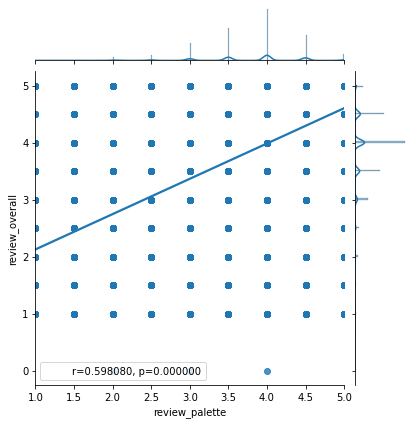

In [105]:
get_cor_plot('review_palette', 'review_overall')

Based off these plots, review_aroma is the most important factor.  This is seen by a positive correlation of .78 between the review of the aroma and the review of the overall beer.

## If you were to recommend 3 beers to your friends based on this data which ones will you recommend?

I took a nieve approach to this question.  I would ask my friends what their favorite trait was in beers.  If they answered taste, I would give them the top three for taste.  If they did not have a preference, I would refer them to the overall rating for the top 3 beer selections.  In a more robust analysis, I would find a way to factor out the beers that only have a couple reviews.  I would take an approach to finding ones with less than 3 standard deviations off the mean and remove them, so they do not influence our results.

In [137]:
yea = df.groupby('beer_name')['review_overall'].median()
f2 = yea.to_frame()
test_2 = f2.sort_values(['review_overall'], ascending=[False])
test2 = test_2.head(3)
print('3 Best Beers by Overall Rating')
print(test2)
print('\n')

yea = df.groupby('beer_name')['review_taste'].median()
f2 = yea.to_frame()
test_2 = f2.sort_values(['review_taste'], ascending=[False])
test2 = test_2.head(3)
print('3 Best Beers by Taste Rating')
print(test2)
print('\n')

yea = df.groupby('beer_name')['review_palette'].median()
f2 = yea.to_frame()
test_2 = f2.sort_values(['review_palette'], ascending=[False])
test2 = test_2.head(3)
print('3 Best Beers by Palette Rating')
print(test2)
print('\n')

yea = df.groupby('beer_name')['review_appearance'].median()
f2 = yea.to_frame()
test_2 = f2.sort_values(['review_appearance'], ascending=[False])
test2 = test_2.head(3)
print('3 Best Beers by Appearance Rating')
print(test2)
print('\n')

yea = df.groupby('beer_name')['review_aroma'].median()
f2 = yea.to_frame()
test_2 = f2.sort_values(['review_aroma'], ascending=[False])
test2 = test_2.head(3)
print('3 Best Beers by Aroma Rating')
print(test2)
print('\n')

3 Best Beers by Overall Rating
                            review_overall
beer_name                                 
Kimono Girl                            5.0
Sour Brown Ale                         5.0
Organic Kentucky Christmas             5.0


3 Best Beers by Taste Rating
                        review_taste
beer_name                           
Cuvée Du 5ème                    5.0
Pioneer American Lager           5.0
Steengoed                        5.0


3 Best Beers by Palette Rating
                                                review_palette
beer_name                                                     
Royal Black                                                5.0
Great Lakes Truth Justice And The American Ale             5.0
Flying Magic Zebras                                        5.0


3 Best Beers by Appearance Rating
                    review_appearance
beer_name                            
Braustüb´l Pilsner                5.0
Edsten Triple-Wit                 5.0
Ka

If my friend stated that taste was most important, his/her top three beers would be [Cuvée Du 5ème, Pioneer American Lager, Steengoed].  If my friend states that palette was most important, his/her top three beers would be [Royal Black, Great Lakes Truth Justice And The American Ale, Flying Magic Zebras].  If my friend stated that appearance was the most important, there top 3 would be [Braustüb´l Pilsner, Edsten Triple-Wit, Kannigedda IPA].  If mt friend stated that aroma was the most important, their top 3 would be [Dark Funk 2.0, Sheep In A Tree Red Ale, Old Gander Barley Wine].  If they did not have a preference to any of these qualities, I would recomend the following [Kimono Girl, Sour Brown Ale, Organic Kentucky Christmas].

## Which Beer Style Seems to be the favorite based on Reviews?

For this section, I have to make a couple remarks.  First, I was getting memmory errors, so I took a subset of the data. (100,000 rows)  In a work enviroment, I would get a machine with more ram, use a 64 bit version of python, or run this code on aws or azure.  Second, I only hypertuned one parameter.  I would do more in a work enviroment.  If suited, I would also preform grid search.  Lastly, I went off an approach of using a TF-IDF transformation regressing on the overall scores to learn word importance.  If the overall scores feature was not present in the dataset, I would use an unsupervised approach, such as using the Afinn library, which has a collection of word connetation scores and meanings.  In the supervised regression that I used, I am predicting on training data so there will obviously be a better RMSE since the model has already seen the data.  This model is good however, because if we get text reviews in the future who dont have an overall score with it, we have the perfect model to make sense of this text.  If I were to answer the following questions using the unsupervised approach, I would do the same experiments, just with the opensourced labels to make it a supervised approach.  I also observed the validation plots to make sure the data was not overfitting.

In [14]:
df = df.sample(n = 100000, random_state = 1)
lst = df['review_text'].to_list()
tfidf_vect = TfidfVectorizer(stop_words='english', max_features=100)
corpus = lst
x = tfidf_vect.fit(corpus)
x = tfidf_vect.transform(corpus)

df_new = pd.DataFrame(x.toarray(), columns = tfidf_vect.get_feature_names())
app = list(df['review_overall'])
df_new['target'] = app
y = df_new['target']
x = df_new.drop(['target'], axis = 1)

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 55, test_size= 0.25)

In [6]:
l_r = [0.0001, .001, .01, .1, .5]
rmse_train = []
rmse_test = []
r_squ_train = []
r_squ_test = []

for i in l_r:
    clf = GradientBoostingRegressor(learning_rate=i)
    clf.fit(x_train, y_train)
    pred_train = clf.predict(x_train)
    pred_test = clf.predict(x_test)
    rmse_train.append(np.sqrt(metrics.mean_squared_error(y_train, pred_train)))
    rmse_test.append(np.sqrt(metrics.mean_squared_error(y_test, pred_test)))
    r_squ_train.append((metrics.r2_score(y_train, pred_train)))
    r_squ_test.append((metrics.r2_score(y_test, pred_test)))

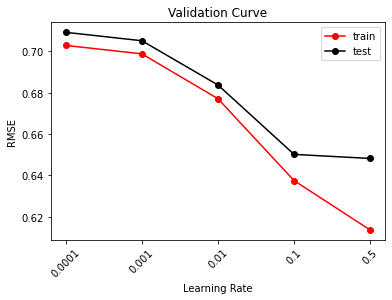

In [7]:
plt.plot(rmse_train, marker='o', color = 'red', label = 'train')
plt.plot(rmse_test, marker = 'o', color = 'black', label = 'test')
plt.title('Validation Curve')
plt.xticks(ticks=np.arange(len(l_r)), labels=l_r, rotation=45)
plt.xlabel('Learning Rate')
plt.ylabel('RMSE')
plt.legend()
plt.show()

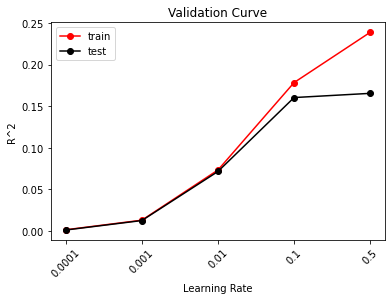

In [8]:
plt.plot(r_squ_train, marker='o', color = 'red', label = 'train')
plt.plot(r_squ_test, marker = 'o', color = 'black', label = 'test')
plt.title('Validation Curve')
plt.xticks(ticks=np.arange(len(l_r)), labels=l_r, rotation=45)
plt.xlabel('Learning Rate')
plt.ylabel('R^2')
plt.legend()
plt.show()

In [11]:
clf = GradientBoostingRegressor(learning_rate=.1)
clf.fit(x_train, y_train)
predictions = clf.predict(df_new.drop(['target'], axis = 1))
df['pred'] = list(predictions)
rank = df.groupby('beer_style')['pred'].median()
rank = rank.to_frame()
test_2 = rank.sort_values(['pred'], ascending=[False])
test2 = test_2.head(1)
print('Best Beer Style based on Reviews Written')
print(test2)

Best Beer Style based on Reviews Written
                   pred
beer_style             
Oatmeal Stout  3.995686


The best beer style off this analysis was Oatmeal Stout

## Comparing Written Reviews to Overall Rewiews

To look at the difference between the written reviews and the overall reviews, we can take a look at the preformance metrics of our gradient boosting regression model to intrepret the results.  Our best model had a RMSE of .65 for the test data and a r^2 of .15 for the test data.  From this and assuming a normal distribution on the residuals (in further analysis I would run tests to see if residuals were normal) and taking account of the emperical rule, we can say that if we had a written review that got a predicted value of 3, 68% of the time the actual value will be between [2.35, 3.65], 95% of the time the actual value will be between [1.7, 4.3] and 99% of the time will be between [1.05, 4.95].  Since the testing r^2 is .15, we can state that 15% of the variance in the overall rating can be explained by the written review.

## How do you find Similar Beer Drinkers by Using Reviews Only?

For this problem, I would compute a matrix of TF-IDF for the text reviews.  I would then compute the cosine similarity to work as a collaboratibe filtering system.  Then, I could feed a review into the recomender system, and this function would return the top N reviewer_profileNames with similar reviews.  This is a recomender system based of computing the TF-IDF of the written reviews and the cosine similarity between them.  